# M3 - Imagen

Este módulo es el núcleo del sistema de visión artificial. Operativamente está compuesto por cuatro bloques funcionales que siguen el flujo recogido en la {numref}`Figura_WP1_imagen.6`:

```{figure} .././assets/Modulo-3.png
:name: Figura_WP1_imagen.6
:alt: UML del modúlo de visión artificial
:width: 25%
:align: center

Bloques funcionales del módulo de imagen (visión artificial)
```
El motor de este módulo se sustenta sobre el algoritmo GrabCut. GrabCut es un método semiautomático para segmentar objetos en una imagen, es decir, para separar una región de interés del resto de la escena. Fue propuesto en 2004 por Rother, Kolmogorov y Blake [[Rother et al., 2004](https://doi.org/10.1145/1015706.1015720)], y se ha convertido en una herramienta clásica en visión por computadora debido a su equilibrio entre precisión y facilidad de uso.

En su planteamiento original, el algoritmo necesita una pequeña intervención del usuario para trazar un rectángulo que contenga aproximadamente el objeto que se desea extraer. A partir de ahí, GrabCut trabaja de forma iterativa para refinar la segmentación sin necesidad de más entradas, aunque también permite correcciones manuales si es necesario.

Matemáticamente, GrabCut modela los colores del objeto (primer plano o foreground) y del entorno (fondo o background) mediante modelos de mezcla gaussiana (GMM, por sus siglas en inglés)[[Bishop, 2006](https://doi.org/10.1007/978-1-4615-7566-5)]. Estos modelos permiten representar distribuciones complejas de color como la combinación de varias campanas gaussianas, cada una capturando un tono o textura característica. Así, en lugar de asumir que todos los píxeles del objeto tienen el mismo color, el GMM reconoce que pueden existir múltiples modos (o grupos) de colores dentro de la misma región.

Además del color, GrabCut también considera la estructura espacial de la imagen: píxeles cercanos tienden a pertenecer a la misma clase. Esta idea se modela mediante un campo aleatorio de Markov (MRF), que penaliza soluciones en las que píxeles vecinos tienen etiquetas muy diferentes sin una justificación clara en los datos (por ejemplo, un cambio brusco de color). De esta forma, se evitan segmentaciones irregulares o con ruido [[Li, 2009](https://doi.org/10.1007/978-1-84882-437-9)].

Todo esto se combina en una función de energía que mide lo “buena” que es una segmentación propuesta. Minimizar esta energía equivale a encontrar la máscara que mejor explica los colores observados (usando los GMMs) y que, al mismo tiempo, sea espacialmente coherente (gracias al MRF).

En el contexto de FLATCLASS este algoritmo se ha adaptado para no contar con intervención humana inicial. Para aislar el objeto de interés (lenguado) se ha usado una cinta transportadora de color azul, cuyo tono varía ligeramente debido a iluminación escasa, no homogénea, sombras, presencia de gotas de agua o textura del material. Dado que el objeto y el fondo tienen colores claramente distintos, y aún asumiendo que el fondo no es uniforme, se puede indicar al algoritmo que el fondo es predominantemente azul y que el objeto (lenguado) ocupa aproximadamente el centro de la imagen ({numref}`Figura_WP1_imagen.7`).  

```{figure} .././assets/P22C-ML_0_calibrated.png
:name: Figura_WP1_imagen.7
:alt: Captura de lenguado
:width: 50%
:align: center

Imagen real de lenguado obtenida con el sistema de captura
```

Para mejorar la detección, el *pipeline* acorta el área de exploración al rectángulo que engloba la cinta y el pez, definiendo de forma automática la región de interés (ROI). Para ello se usa detección cromática robusta de la cinta azul y en un análisis perfilado por columnas que localiza el tramo contiguo donde la cobertura del color azul es dominante a lo largo de toda la altura de la imagen. Primero, el prefiltrado (NLMeans + bilateral + CLAHE) estabiliza ruido e iluminación para que el tono azul sea más estable espectralmente (el bilateral preserva bordes [[Tomasi et al., 1998](https://www.academia.edu/103435418/Bilateral_filtering_for_gray_and_color_images)]. A continuación, en espacio HSV se estima de forma adaptativa el intervalo cromático del azul calculando el pico del histograma del matiz (H) en una banda central y con saturación alta (S) —estrategia inspirada en histogramas de color para indexación/segmentación—, lo que compensa variaciones de cámara e iluminación. Con ese umbral dinámico se genera una máscara binaria “azul”; sobre ella, para cada columna $j$ se computa la razón de cobertura azul $r_j=\dfrac{1}{H} \sum^H_{y=1} {blue(y,j)}$. Se marcan como "cinta" las columnas con $r_j \geq \tau$ y se elige el tramo contíguo más largo $[x_1,x_2]$ de columnas que cumplen el criterio. Esto elimina de forma natural las columnas metálicas laterales correspondientes al soporte de la cámara (fotografía {numref}`Figura_WP1_imagen.7`), que o bien tienen $r_j$ bajo o aparecen como tramos cortos no contiguos.

En vertical se repite el razonamiento sobre filas dentro de $[x_1,x_2]$ para obtener $[y_1,y_2]$. El ROI final es el rectángulo acolchado $R=(x,y,w,h)$ que engloba $[x_1,x_2] \times [y_1,y_2]$. Esta determinación geométrica evita depender de cierres morfológicos agresivos (que pueden “invadir” el metal) y se apoya en principios de morfología matemática y conectividad [[Soille, 2003](https://link.springer.com/book/10.1007/978-3-662-05088-0)]. La ROI así calculada se utiliza después para restringir GrabCut, etiquetando como "probable fondo" los bordes de la imagen y como "probable primer plano" la región central, al tiempo que se definen en el código tonos de azul como semillas reforzadas para GrabCut, garantizando que la segmentación psoterior se concentre en el pez y la cinta [[Rother et al., 2004](https://doi.org/10.1145/1015706.1015720)].
 

In [1]:
import cv2
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# -------------------------
# CONFIG
# -------------------------
CONFIG = {
    "img_path": "./original.png",
    "out_prefix": "./out/sole_",
    "pad_roi": 12,

    # Prefilter
    "nlmeans_h": 5,
    "bilateral_d": 9, "bilateral_sigmaC": 50, "bilateral_sigmaS": 50,
    "clahe_clip": 2.0, "clahe_tiles": (8, 8),

    # Dynamic blue threshold
    "blue_sat_min": 80,
    "blue_half_window": 15,

    # ROI by blue column coverage
    "belt_col_cover_ratio": 0.22,
    "belt_min_width_px": 200,

    # GrabCut
    "pr_fg_kernel": (7, 19),
    "sure_fg_pct_contrast": 70,
    "sure_fg_pct_dt": 60,
    "gc_iters": 12,

    # Guard-rails (BG) inside ROI
    "guard_frac_w": 0.03,
    "guard_min_px": 14,
    "guard_max_px": 48,

    # Postprocess
    "post_close_kernel": (9, 13),

    # Candidate filter & shape prior (STRICT)
    "min_area_px2": 5000,
    "min_width_px": 32,
    "edge_clear_px": 16,
    "shape_mu_log_aspect": 0.92,  # ~aspect 2.5
    "shape_sigma": 0.35,

    # Relaxed fallback deltas (used if strict fails)
    "relax": {
        "min_area_px2": 1500,
        "min_width_px": 14,
        "edge_clear_px": 6,
        "shape_sigma": 0.70,
        "allow_touch_edges": True
    },

    # Optional metric scale
    "scale_json": "./calibracion_px_mm.json",

    # --- switches ---
    "debug": True,     # PNGs on/off
    "save_csv": True    # CSV on/off
}

# -------------------------
# Utilities
# -------------------------
def _dbg() -> bool:
    return bool(CONFIG.get("debug", False))

def _ensure_dir(path: str):
    Path(path).parent.mkdir(parents=True, exist_ok=True)

def save_img(name: str, img) -> str:
    """Unconditional file save (internal)."""
    p = CONFIG["out_prefix"] + name
    _ensure_dir(p)
    if img.ndim == 2:
        cv2.imwrite(p, img)
    else:
        cv2.imwrite(p, img if img.shape[2] == 3 else img[..., :3])
    return p

def save_img_dbg(name: str, img):
    """Save only if CONFIG['debug'] is True; otherwise return None."""
    if not _dbg():
        return None
    return save_img(name, img)

def save_csv_dbg(df: pd.DataFrame, name: str):
    """Save CSV only if CONFIG['save_csv'] is True; returns path or None."""
    if not CONFIG.get("save_csv", False):
        return None
    out_path = CONFIG["out_prefix"] + name
    _ensure_dir(out_path)
    df.to_csv(out_path, index=False)
    return out_path

def get_scale_mm_per_px() -> float | None:
    try:
        from get_mm_per_px import get_mm_per_px  # type: ignore
        val = float(get_mm_per_px())
        if val > 0:
            return val
    except Exception:
        pass
    p = Path(CONFIG["scale_json"])
    if p.exists():
        try:
            data = json.loads(p.read_text())
            val = float(data.get("mm_per_px", 0))
            if val > 0:
                return val
        except Exception:
            pass
    return None

# ---- Morphology helpers to avoid kernel errors ----
def _morph(img: np.ndarray, op: int, shape: int, ksize: tuple[int,int], iters: int = 1) -> np.ndarray:
    """
    Robust wrapper for cv2.morphologyEx:
    - Ensures uint8 input
    - Always builds a valid kernel
    - Uses positional args for compatibility
    """
    if img.dtype != np.uint8:
        if img.dtype == bool:
            img = img.astype(np.uint8) * 255
        else:
            img = img.astype(np.uint8)
    k = cv2.getStructuringElement(shape, (int(ksize[0]), int(ksize[1])))
    return cv2.morphologyEx(img, op, k, None, None, int(iters), cv2.BORDER_CONSTANT, 0)

def _open(img: np.ndarray, shape: int, ksize: tuple[int,int], iters: int = 1) -> np.ndarray:
    return _morph(img, cv2.MORPH_OPEN, shape, ksize, iters)

def _close(img: np.ndarray, shape: int, ksize: tuple[int,int], iters: int = 1) -> np.ndarray:
    return _morph(img, cv2.MORPH_CLOSE, shape, ksize, iters)

# -------------------------
# Pipeline blocks
# -------------------------
def prefilter(bgr: np.ndarray) -> np.ndarray:
    den = cv2.fastNlMeansDenoisingColored(
        bgr, None, h=CONFIG["nlmeans_h"], hColor=CONFIG["nlmeans_h"],
        templateWindowSize=7, searchWindowSize=21
    )
    den = cv2.bilateralFilter(
        den, d=CONFIG["bilateral_d"],
        sigmaColor=CONFIG["bilateral_sigmaC"], sigmaSpace=CONFIG["bilateral_sigmaS"]
    )
    hsv = cv2.cvtColor(den, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    clahe = cv2.createCLAHE(CONFIG["clahe_clip"], CONFIG["clahe_tiles"])
    v = clahe.apply(v)
    out = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2BGR)
    save_img_dbg("01_prefilter.png", out)
    return out

def dynamic_blue_threshold(hsv: np.ndarray):
    H, S, _ = cv2.split(hsv)
    Hh, Wh = H.shape
    x1, x2 = int(Wh * 0.32), int(Wh * 0.68)
    band = H[:, x1:x2]; band_s = S[:, x1:x2]
    mask_sat = band_s > CONFIG["blue_sat_min"]
    hh = band[mask_sat].flatten()
    if hh.size == 0:
        lower = np.array([95, 100, 30], np.uint8)
        upper = np.array([125, 255, 255], np.uint8)
    else:
        hist = cv2.calcHist([hh.astype(np.uint8)], [0], None, [180], [0, 180]).flatten()
        peak = int(np.argmax(hist)); hw = CONFIG["blue_half_window"]
        lower = np.array([max(0, peak - hw), 80, 30], np.uint8)
        upper = np.array([min(179, peak + hw), 255, 255], np.uint8)
    return lower, upper

def _longest_true_run(vec_bool: np.ndarray):
    best_i = best_j = -1; cur_i = -1
    for k, v in enumerate(vec_bool):
        if v:
            if cur_i < 0: cur_i = k
        else:
            if cur_i >= 0:
                if best_i < 0 or (k-1 - cur_i) > (best_j - best_i):
                    best_i, best_j = cur_i, k-1
                cur_i = -1
    if cur_i >= 0:
        k = len(vec_bool)
        if best_i < 0 or (k-1 - cur_i) > (best_j - best_i):
            best_i, best_j = cur_i, k-1
    return None if best_i < 0 else (best_i, best_j)

def belt_roi_from_blue(hsv: np.ndarray, lower: np.ndarray, upper: np.ndarray):
    """
    ROI = rectángulo sobre la cinta:
    - Umbral HSV → máscara azul
    - Cobertura azul por columna y tramo contiguo más largo
    - Rango vertical por filas en ese tramo
    """
    H, W = hsv.shape[:2]
    blue_raw = cv2.inRange(hsv, lower, upper).astype(np.uint8)
    blue = _open(blue_raw, cv2.MORPH_RECT, (3, 3), 1)
    blue = cv2.medianBlur(blue, 3)

    col_counts = (blue > 0).sum(axis=0).astype(np.int32)
    cover_ratio = col_counts / float(H)
    col_mask = cover_ratio >= CONFIG["belt_col_cover_ratio"]
    run = _longest_true_run(col_mask)
    if run is None:
        raise RuntimeError("No se identificó ningún tramo de cinta por cobertura azul.")
    x1, x2 = run
    if (x2 - x1 + 1) < CONFIG["belt_min_width_px"]:
        relax = max(0.02, 0.5 * CONFIG["belt_col_cover_ratio"])
        col_mask_relaxed = cover_ratio >= (CONFIG["belt_col_cover_ratio"] - relax)
        run2 = _longest_true_run(col_mask_relaxed)
        if run2 is None or (run2[1] - run2[0] + 1) < CONFIG["belt_min_width_px"]:
            raise RuntimeError("La anchura estimada de la cinta es demasiado pequeña.")
        x1, x2 = run2

    blue_slice = blue[:, x1:x2 + 1]
    row_counts = (blue_slice > 0).sum(axis=1).astype(np.int32)
    row_mask = row_counts >= max(1, int(0.02 * (x2 - x1 + 1)))
    row_run = _longest_true_run(row_mask)
    y1, y2 = (0, H - 1) if row_run is None else row_run

    pad = CONFIG["pad_roi"]
    x = max(0, x1 - pad); y = max(0, y1 - pad)
    w = min(W - x, (x2 - x1 + 1) + 2 * pad)
    h = min(H - y, (y2 - y1 + 1) + 2 * pad)

    dbg = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    cv2.rectangle(dbg, (x, y), (x + w, y + h), (255, 0, 255), 3)
    vis = dbg.copy()
    vis[:, col_mask, :] = cv2.addWeighted(vis[:, col_mask, :], 0.5, np.full_like(vis[:, col_mask, :], (255, 0, 0)), 0.5, 0)
    save_img_dbg("02b_belt_columns.png", vis)
    save_img_dbg("03_roi_debug.png", dbg)
    save_img_dbg("02_blue_mask.png", blue_raw)
    return (x, y, w, h), blue

def seeds_in_roi(bgr_roi: np.ndarray, lower: np.ndarray, upper: np.ndarray):
    hsv = cv2.cvtColor(bgr_roi, cv2.COLOR_BGR2HSV)
    blue = cv2.inRange(hsv, lower, upper).astype(np.uint8)
    not_blue = cv2.bitwise_not(blue)

    k_vert = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, CONFIG["pr_fg_kernel"])
    pr_fg = cv2.dilate(not_blue, k_vert, iterations=1)

    h, s, _ = cv2.split(hsv)
    belt_h = h[blue > 0].astype(np.float32); belt_s = s[blue > 0].astype(np.float32)
    if belt_h.size:
        mu_h, mu_s = float(np.median(belt_h)), float(np.median(belt_s))
        dh = cv2.absdiff(h.astype(np.int16), np.full_like(h, int(mu_h), np.int16)).astype(np.uint8)
        ds = cv2.absdiff(s.astype(np.int16), np.full_like(s, int(mu_s), np.int16)).astype(np.uint8)
        contrast = cv2.addWeighted(dh, 0.7, ds, 0.3, 0)
        thr = int(np.percentile(contrast, CONFIG["sure_fg_pct_contrast"]))
        _, hi = cv2.threshold(contrast, thr, 255, cv2.THRESH_BINARY)
        sure_fg = cv2.bitwise_and(hi, not_blue)
        save_img_dbg("07_contrast.png", cv2.normalize(contrast, None, 0, 255, cv2.NORM_MINMAX))
    else:
        sure_fg = cv2.erode(pr_fg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9)), 1)

    dist = cv2.distanceTransform((pr_fg > 0).astype(np.uint8), cv2.DIST_L2, 5)
    if np.any(dist > 0):
        th = np.percentile(dist[dist > 0], CONFIG["sure_fg_pct_dt"])
        sure_fg |= (dist > th).astype(np.uint8) * 255

    gc_mask = np.full(blue.shape, cv2.GC_PR_BGD, np.uint8)
    gc_mask[blue > 0]    = cv2.GC_BGD
    gc_mask[pr_fg > 0]   = cv2.GC_PR_FGD
    gc_mask[sure_fg > 0] = cv2.GC_FGD

    # Horizontal borders as BG
    m = 6
    gc_mask[:m, :]  = cv2.GC_BGD
    gc_mask[-m:, :] = cv2.GC_BGD
    # Lateral guard-rails as BG
    W = gc_mask.shape[1]
    g = int(CONFIG["guard_frac_w"] * W)
    g = max(CONFIG["guard_min_px"], min(CONFIG["guard_max_px"], g))
    gc_mask[:, :g]  = cv2.GC_BGD
    gc_mask[:, -g:] = cv2.GC_BGD

    save_img_dbg("04_pr_fg.png", pr_fg)
    save_img_dbg("05_sure_fg.png", sure_fg)
    save_img_dbg("06_not_blue.png", not_blue)
    save_img_dbg("08_gc_seeds.png", (gc_mask * (255 // 3)).astype(np.uint8))
    return gc_mask

def render_candidates_debug(bgr_base: np.ndarray,
                            cnts: list,
                            scores: list,
                            best_idx: int | None,
                            roi_xywh: tuple[int,int,int,int],
                            tag: str):
    """Writes PNG only in debug; returns path or None."""
    if not _dbg():
        return None
    vis = bgr_base.copy()
    xR, yR, wR, hR = roi_xywh
    cv2.rectangle(vis, (xR, yR), (xR + wR, yR + hR), (255, 0, 255), 2)

    sc = np.array(scores, dtype=np.float32) if scores else np.array([], np.float32)
    if sc.size:
        sc[~np.isfinite(sc)] = 0.0
        scn = (sc - sc.min()) / max(1e-9, sc.max() - sc.min()) if not np.all(sc == sc[0]) else np.zeros_like(sc)

    for i, c in enumerate(cnts):
        color = (0, 0, 255); thick = 2
        if best_idx is not None and i == best_idx:
            color = (0, 255, 0); thick = 3
        cv2.drawContours(vis, [c], -1, color, thick)
        x, y, w, h = cv2.boundingRect(c)
        s = scores[i] if i < len(scores) else float("nan")
        txt = f"s={s:.0f}  {w}x{h}"
        y_txt = max(15, y - 5)
        (tw, th), _ = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, 0.45, 1)
        cv2.rectangle(vis, (x, y_txt - th - 4), (x + tw + 4, y_txt + 2), (0, 0, 0), -1)
        cv2.putText(vis, txt, (x + 2, y_txt), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1, cv2.LINE_AA)
        if sc.size and (best_idx is None or i != best_idx):
            alpha = float(0.35 + 0.45 * scn[i])
            cv2.drawContours(vis, [c], -1, tuple(int(alpha * v) for v in color), 2)

    return save_img(f"10_candidates_{tag}.png", vis)

def contour_scores(cnts, roi, strict=True):
    xR, yR, wR, hR = roi
    if strict:
        min_area = CONFIG["min_area_px2"]
        min_width = CONFIG["min_width_px"]
        edge_clear = CONFIG["edge_clear_px"]
        mu = CONFIG["shape_mu_log_aspect"]
        sg = CONFIG["shape_sigma"]
        allow_touch_edges = False
    else:
        min_area = CONFIG["relax"]["min_area_px2"]
        min_width = CONFIG["relax"]["min_width_px"]
        edge_clear = CONFIG["relax"]["edge_clear_px"]
        mu = CONFIG["shape_mu_log_aspect"]
        sg = CONFIG["relax"]["shape_sigma"]
        allow_touch_edges = CONFIG["relax"]["allow_touch_edges"]

    def score(c):
        A = cv2.contourArea(c)
        if A < min_area:
            return -np.inf
        x0, y0, w0, h0 = cv2.boundingRect(c)
        if min(w0, h0) < min_width:
            return -np.inf
        if not allow_touch_edges:
            if (xR + x0) < (xR + edge_clear) or (xR + x0 + w0) > (xR + wR - edge_clear):
                return -np.inf
        a = max(w0, h0) / max(1.0, min(w0, h0))
        w_aspect = np.exp(-((np.log(a) - mu) ** 2) / (2.0 * (sg ** 2)))
        hull = cv2.convexHull(c)
        Ah = cv2.contourArea(hull)
        solidity = (A / Ah) if Ah > 0 else 0.0
        w_sol = np.clip(solidity, 0.0, 1.0)
        return float(A * w_aspect * (0.6 + 0.4 * w_sol))

    return [score(c) for c in cnts]

# -------------------------
# Run
# -------------------------
def extractor():
    IMG_PATH = CONFIG["img_path"]
    bgr0 = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
    if bgr0 is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {IMG_PATH}")

    # 1) Prefilter
    bgr = prefilter(bgr0)

    # 2) Dynamic blue & ROI
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    lower, upper = dynamic_blue_threshold(hsv)
    roi, _ = belt_roi_from_blue(hsv, lower, upper)
    x, y, w, h = roi
    crop = bgr[y:y + h, x:x + w].copy()

    # 3) GrabCut seeds + run
    gc_mask = seeds_in_roi(crop, lower, upper)
    bg_model = np.zeros((1, 65), np.float64)
    fg_model = np.zeros((1, 65), np.float64)
    cv2.grabCut(crop, gc_mask, None, bg_model, fg_model, CONFIG["gc_iters"], cv2.GC_INIT_WITH_MASK)

    # 4) Post-process mask
    mask_roi = np.where((gc_mask == cv2.GC_FGD) | (gc_mask == cv2.GC_PR_FGD), 1, 0).astype(np.uint8)
    save_img_dbg("09_mask_roi_raw.png", (mask_roi * 255))
    mask_roi = _close(mask_roi, cv2.MORPH_ELLIPSE, CONFIG["post_close_kernel"], 1)
    mask_roi = _open(mask_roi,  cv2.MORPH_ELLIPSE, (5, 5), 1)

    full = np.zeros(bgr.shape[:2], np.uint8)
    full[y:y + h, x:x + w] = mask_roi

    # 5) Contours & scoring (strict → relaxed fallback)
    cnts, _ = cv2.findContours((full * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    scores_strict = contour_scores(cnts, roi, strict=True) if cnts else []
    best_idx = int(np.argmax(scores_strict)) if scores_strict else None
    strict_ok = bool(scores_strict) and np.isfinite(scores_strict[best_idx]) and (scores_strict[best_idx] > 0)
    _ = render_candidates_debug(bgr0, cnts, scores_strict, best_idx if strict_ok else None, roi, tag="strict")

    if not strict_ok:
        scores_relax = contour_scores(cnts, roi, strict=False) if cnts else []
        best_idx_relax = int(np.argmax(scores_relax)) if scores_relax else None
        relaxed_ok = bool(scores_relax) and np.isfinite(scores_relax[best_idx_relax]) and (scores_relax[best_idx_relax] > 0)
        _ = render_candidates_debug(bgr0, cnts, scores_relax, best_idx_relax if relaxed_ok else None, roi, tag="relaxed")
        if not relaxed_ok:
            if not cnts:
                raise RuntimeError("No contornos tras segmentación.")
            # last-resort: largest area
            areas = [cv2.contourArea(c) for c in cnts]
            use_idx = int(np.argmax(areas))
        else:
            use_idx = best_idx_relax
        used_scores = scores_relax
    else:
        use_idx = best_idx
        used_scores = scores_strict

    cnt = cnts[use_idx]

    # 6) PCA measures
    pts = cnt.reshape(-1, 2).astype(np.float32)
    mean, eigvecs, _ = cv2.PCACompute2(pts, mean=None)
    mean = mean.flatten()
    R = np.asarray(eigvecs, np.float32)
    pts_c = pts - mean
    pts_r = pts_c @ R.T
    min_x, max_x = np.min(pts_r[:, 0]), np.max(pts_r[:, 0])
    min_y, max_y = np.min(pts_r[:, 1]), np.max(pts_r[:, 1])
    length_px = float(max_x - min_x)
    width_px  = float(max_y - min_y)
    area_px2  = float(cv2.contourArea(cnt))

    # 7) Overlay
    rgb = cv2.cvtColor(bgr0, cv2.COLOR_BGR2RGB)
    overlay = rgb.copy()
    box_r = np.array([[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]], np.float32)
    box_img = (box_r @ R) + mean
    box_img = np.int32(box_img)
    cv2.drawContours(overlay, [cnt], -1, (0, 255, 0), 3)
    cv2.polylines(overlay, [box_img], True, (255, 255, 0), 2)
    i_max = np.argmax(pts_r[:, 0]); i_min = np.argmin(pts_r[:, 0])
    p1 = (np.array([pts_r[i_min, 0], 0.0], np.float32) @ R) + mean
    p2 = (np.array([pts_r[i_max, 0], 0.0], np.float32) @ R) + mean
    cv2.line(overlay, tuple(np.int32(p1)), tuple(np.int32(p2)), (255, 0, 0), 2)
    cv2.rectangle(overlay, (x, y), (x + w, y + h), (255, 0, 255), 2)

    # 8) Units
    mm_per_px = get_scale_mm_per_px()
    if mm_per_px and np.isfinite(mm_per_px) and mm_per_px > 0:
        length_mm = length_px * mm_per_px
        width_mm  = width_px  * mm_per_px
        area_mm2  = area_px2  * (mm_per_px ** 2)
    else:
        mm_per_px = float("nan"); length_mm = width_mm = area_mm2 = float("nan")

    # 9) Optional outputs
    mask_full = (full * 255).astype(np.uint8)
    mask_path = save_img_dbg("mask_debug.png", mask_full)
    overlay_path = save_img_dbg("overlay_debug.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    df = pd.DataFrame([{
        "image_path": IMG_PATH,
        "roi_x": x, "roi_y": y, "roi_w": w, "roi_h": h,
        "length_px": length_px, "width_px": width_px, "area_px2": area_px2,
        "mm_per_px": float(mm_per_px) if np.isfinite(mm_per_px) else np.nan,
        "length_mm": float(length_mm) if np.isfinite(length_mm) else np.nan,
        "width_mm": float(width_mm) if np.isfinite(width_mm) else np.nan,
        "area_mm2": float(area_mm2) if np.isfinite(area_mm2) else np.nan,
        "best_score": float(used_scores[use_idx]) if (used_scores and np.isfinite(used_scores[use_idx])) else np.nan
    }])
    csv_path = save_csv_dbg(df, "measurements_debug.csv")

    return {
        "roi": (x, y, w, h),
        "length_px": length_px, "width_px": width_px, "area_px2": area_px2,
        "mm_per_px": mm_per_px, "length_mm": length_mm, "width_mm": width_mm, "area_mm2": area_mm2,
        "mask_img": mask_full, "overlay_img": overlay,
        "mask_path": mask_path, "overlay_path": overlay_path, "csv_path": csv_path,
        "df": df
    }

El algoritmo de visión desarrollado se sustenta sobre una seria de funciones, cada una responsable de resolver el bloque operativo definido en la {numref}`Figura_WP1_imagen.6`.

## Preprocesado

Este bloque funcional se sustenta sobre las siguientes funciones:

* **prefilter(bgr).** Toma como entrada una imagen BGR (`np.ndarray`) y devuelve una versión prefiltrada en BGR tras aplicar NLMeans (reducción de ruido no local), filtro bilateral (suavizado que preserva bordes) y CLAHE en el canal V (HSV). Su utilidad es mejorar la relación señal-ruido y homogeneizar la iluminación antes de la segmentación, estabilizando los modelos de apariencia usados por GrabCut y reduciendo artefactos de borde; en términos prácticos, atenúa alta frecuencia sin degradar discontinuidades relevantes (cabeza/cola del pez frente a la cinta).

* **dynamic_blue_threshold(hsv).** Recibe una imagen en HSV y retorna dos vectores `lower` y `upper` (umbrales HSV) que acotan dinámicamente el color azul de la cinta. Estima el pico del histograma del canal H en una franja vertical central (filtrada por saturación mínima) y construye un intervalo $[\,H_0\pm\Delta H\,]$. Su utilidad es adaptar la detección del fondo (cinta) a cambios de cámara/iluminación, reforzando la separación fondo (azul) / no-fondo para las semillas de GrabCut.

* **_longest_true_run(vec_bool)** Realiza una búsqueda lineal del tramo contiguo máximo de verdaderos. Como parámetro de entrada necesita un vector booleano 1D (np.ndarray) y devuelve $(i, j)$ (índices inclusive) del segmento más largo con *True*, o *None* si no existe. Se usa para fijar límites horizontales (columnas) y verticales (filas) de la cinta.

* **belt_roi_from_blue(hsv, lower, upper).** Recibe la imagen HSV y los umbrales `lower/upper`; devuelve la ROI de la cinta como tupla `(x, y, w, h)` y la máscara binaria `blue`. Umbraliza el azul, limpia con operaciones morfológicas (apertura/cierre) y toma el *bounding box* de la mayor componente conexa, expandiéndolo con *padding*. Su utilidad es anclar espacialmente el problema: restringe la segmentación a la banda transportadora (banda a banda), evitando que estructuras ajenas (p. ej., metálicas) perturben la optimización.

* **_morph(img, op, shape, ksize, iters=1)** Se trata de un envoltorio de la interfaz de OpenCV `cv2.morphologyEx` usada para aplicar operaciones morfológicas apertura, cierre, gradiente morfológico, tophat, blackhat, hit-or-miss) sobre la imagen. Como entrada necesita: img (np.uint8 o convertible), op (operación de OpenCV), shape (tipo de elemento estructurante), ksize (tupla de tamaño), iters (int) retornando la imagen procesada (np.ndarray) y evitando errores de resolución de sobrecarga.

* **_open(img, shape, ksize, iters=1)** Aplica una apertura morfológica especializada con `cv2.MORPH_OPEN`. Se usa para eliminar ruido fino preservando estructuras mayores.

* **_close(img, shape, ksize, iters=1)** Aplica un cierre morfológico especializado. Misma signatura que `_open` pero con `cv2.MORPH_CLOSE`. Rellena huecos/pequeñas discontinuidades en máscaras binarizadas; devuelve np.ndarray.

## Segmentación

* **seeds_in_roi(bgr_roi, lower, upper).** Recibe el recorte BGR de la ROI y los umbrales HSV; devuelve `gc_mask`, una máscara de estados entera con etiquetas de GrabCut {BG seguro, PR_BG, PR_FG, FG}. Construye las semillas así: (i) **BG seguro** = píxeles azules; (ii) **PR_FG** = no-azul dilatado con kernel anisotrópico (alto y estrecho) para conectar zonas finas (cola/cabeza); (iii) **FG seguro** = no-azul con alto contraste cromático respecto al azul (combinación de distancias en H y S umbraladas por percentil), reforzado mediante **distance transform** sobre PR_FG; además fija el borde de la ROI como BG. Su utilidad es condicionar favorablemente la minimización de la energía de GrabCut (término de datos GMM + término de suavidad por corte en grafo), reduciendo fugas y pérdidas en extremos.

## Selección y medición

* **contour_scores(cnts, roi, strict=True)** Realiza una ponderación morfológica de candidatos. Como entredas necesita: contornos `cnts`, ROI `(x,y,w,h)` y un crietrio de severidad. Para cada contorno calcula `score = área × prior(log-aspecto) × solidez`, aplicando filtros de área, anchura mínima y proximidad a bordes (relajables en modo *non-strict*). Devuelve una lista de `float` alineada con `cnts`.

* **extractor().** No recibe argumentos y devuelve: `overlay_path`, `mask_path`, `csv_path` (rutas), `length_px`, `width_px`, `area_px2` (magnitudes en píxeles), `mm_per_px` (si existe) y la `roi` empleada. Orquesta todo el pipeline: carga y prefiltra la imagen; estima el umbral azul dinámico y extrae la ROI de la cinta; genera semillas y ejecuta GrabCut con iteraciones configurables; aplica postproceso morfológico (cierre/apertura); selecciona el contorno del pez por área + alargamiento; calcula **longitud** y **anchura** proyectando el contorno sobre los autovectores de la **PCA** (extensión $\max-\min$ en cada eje) y el **área** con `cv2.contourArea`; finalmente guarda las salidas (overlay, máscara y CSV) y convierte a unidades métricas si hay factor de escala disponible.

## Otras funciones

El pipeline también proporciona algunas funciones auxiliares como:

* **render_candidates_debug(bgr_base, cnts, scores, best_idx, roi_xywh, tag)** Es una función útil en una auditoría visual del criterio de selección. Como entradas necesita: imagen base, lista de contornos, lista de scores, índice del mejor (o `None`), ROI `(x,y,w,h)` y etiqueta de texto. Dibuja ROI y contornos (verde el seleccionado, rojo el resto) con anotación de puntuación y guarda el fichero .PNG sólo en modo `debug`, devolviendo su ruta o `None`.

* **save_img(name, img)** Guarda las imágenes obtendias en los procesos anteriores. Como variables de entrada usa: `name (str)` e `img (np.ndarray, BGR o 1 canal)`. Escribe el array en disco en con el parámetro `CONFIG["out_prefix"]+name` y devuelve la ruta escrita `(str)`. Esta función centraliza la serialización de artefactos visuales.

* **save_img_dbg(name, img)** Esta función es similar a la anterior(recibe los mismos parámetros que `save_img`) pero sólo guarda si `CONFIG["debug"]==True`. Devuelve la ruta escrita o `None` si no hubo escritura. Implementa además el patrón de side-effects controlados por flag.

* **save_csv_dbg(df, name)** Garantiza la persistencia de los resultados del proceso en formato CSV sólo si `CONFIG["save_csv"]==True`. Los parámetros de entreda son un `df (DataFrame de Pandas)` y el nombre `name (str)` del fichero. Guarda el CSV en `CONFIG["out_prefix"]+name` y devuelve la ruta o `None`. Permite desacoplar cómputo en memoria de la E/S de informes.

* **get_scale_mm_per_px().** No recibe argumentos y devuelve el factor escalar `mm_per_px` (flotante) o `None` si no está disponible. Internamente busca primero una función externa del usuario `get_mm_per_px()` y, en su defecto, un fichero `calibracion_px_mm.json` con la clave `"mm_per_px"`, que debería existir tras haber realizado una calibración. Su utilidad es habilitar la conversión métrica de las magnitudes geométricas estimadas en píxeles —longitud, anchura y área.


Para ejecutar el pipeline basta con:

Área de interés (ROI): (368, 0, 1114, 1080)
Medidas detectadas: L=745.1px  W=293.4px  A=152108.0px^2
Medidas reales: L=37.25 mm  W=14.67 mm  A=380.27 mm^2  Resolución 0.050000 mm/px
PNG overlay guardado: ./out/sole_overlay_debug.png
PNG máscara guardado: ./out/sole_mask_debug.png
CSV datos: ./out/sole_measurements_debug.csv


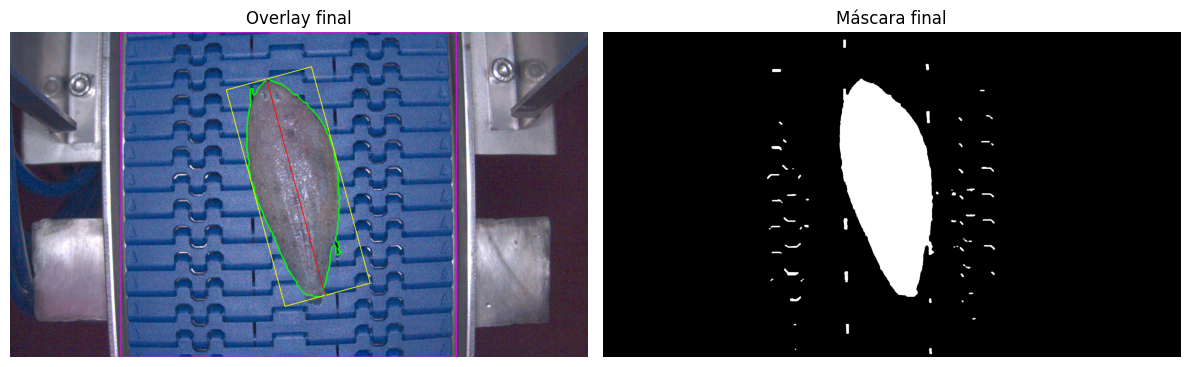

In [2]:
# -------------------------
# Execute & (optional) display
# -------------------------
res = extractor()

# Visualización en notebook (no guarda archivos por sí misma)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.title("Overlay final"); plt.imshow(res["overlay_img"]); plt.axis("off")
plt.subplot(1, 2, 2); plt.title("Máscara final"); plt.imshow(res["mask_img"], cmap="gray"); plt.axis("off")
plt.tight_layout()

print(f"Área de interés (ROI): {res['roi']}")
print(f"Medidas detectadas: L={res['length_px']:.1f}px  W={res['width_px']:.1f}px  A={res['area_px2']:.1f}px^2")
if np.isfinite(res["mm_per_px"]):
    print(f"Medidas reales: L={res['length_mm']:.2f} mm  W={res['width_mm']:.2f} mm  A={res['area_mm2']:.2f} mm^2  Resolución {res['mm_per_px']:.6f} mm/px")
print(f"PNG overlay guardado: {res['overlay_path']}")
print(f"PNG máscara guardado: {res['mask_path']}")
print(f"CSV datos: {res['csv_path']}")

Como se puede apreciar en las imágenes del proceso, el *pipeline* define adecuadamente el área de interés al ancho de la cinta (recuadro color violeta) y es capaz detectar el pez (recuadro amarillo) y obtener el contorno (verde) y las medidas del mismo.